# SETUP

In [1]:
USE_GPU = True

In [2]:
!pip install --upgrade pip tensorflow keras &> pip.log
!pip install jupyterlab-vim pydot >> pip.log

if USE_GPU:
    !pip install 'tensorflow[and-cuda]' >> pip.log
else:
    !pip install 'tensorflow-cpu' >> pip.log

!apt-get install graphviz -y &> apt.log

## Libraries

In [3]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
from keras.models import load_model
import keras.backend as K

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data
from src.prediction_model.lstm import predictLSTM, evaluateLSTM
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import predictLSTM, evaluateLSTM
from src.time_series_utils import splitTrainTestTimeSeries, reframePastFuture

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

2.19.0
[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [4]:
confReader = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json")
print(confReader)

conf = confReader.data
print(conf)

{
    "dataset": {
        "aod2022": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx"
        },
        "aod2021": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2021-12-31"
        },
        "mpair": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2022-12-31",
            "station_2022_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2022.csv",
            "station_2018_2021_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2018-2021.csv",
            "merged_data_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_

# MPAIR DATA

## Load dataset

* Every row has a tuple (i, j) which marks a "cell" in the Ho Chi Minh City grid map

| i/j | 0 | 1 | 2 | ... |
|-----|---|---|---|-----|
| 0   |   |   |   |     |
| 1   |   |   |   |     |
| 2   |   |   |   |     |
| ... |   |   |   |     |

* Every cell has its own geographical characteristics
* Every cell represent values of a specific date and specific location

### Raw data

In [5]:
df_mpair_raw = pd.read_csv(conf["dataset"]["mpair"]["merged_data_dir"])
df_mpair_raw

,time,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,...,builtup,cropland,grassland,treecover,water,ndvi,aod,aimodel,station,pm25
0,2021-01-01,16,17,10.789976,106.689516,38.528156,25.759054,61.073494,520.164246,3.809916,...,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,-9999.000000,21.943165,201,17.250000
1,2021-01-02,16,17,10.789976,106.689516,57.013439,25.378061,61.142441,524.404724,2.527972,...,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.317342,31.319979,201,23.000000
2,2021-01-03,16,17,10.789976,106.689516,57.202629,26.691256,62.528309,467.049805,1.928542,...,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,-9999.000000,32.936901,201,28.291667
3,2021-01-04,16,17,10.789976,106.689516,61.890816,27.549019,62.431583,600.658997,1.653818,...,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,-9999.000000,34.197258,201,28.791667
4,2021-01-05,16,17,10.789976,106.689516,70.329758,27.360172,63.041634,654.842773,2.941231,...,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,-9999.000000,25.132664,201,24.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3913,2022-12-27,16,16,10.789976,106.666630,34.151028,24.213715,69.134701,463.417114,2.020892,...,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,-9999.000000,31.959826,216,39.659816
3914,2022-12-28,16,16,10.789976,106.666630,29.592785,25.896009,62.308920,647.989014,2.376687,...,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,-9999.000000,27.823381,216,44.679352
3915,2022-12-29,16,16,10.789976,106.666630,27.141323,25.894251,63.947048,813.575928,2.991689,...,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.193722,25.169254,216,30.724708
3916,2022-12-30,16,16,10.789976,106.666630,19.889748,25.035917,61.037365,668.597046,4.194347,...,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,-9999.000000,20.816696,216,33.091428


In [6]:
df_mpair_raw.columns

Index(['time', 'i', 'j', 'lat', 'lon', 'pm25_3km', 'tmp', 'rh', 'hpbl', 'wspd',
       'pres2m', 'pop', 'road_den_1km', 'road_len_1km', 'prim_road_len_1km',
       'near_dist', 'bareland', 'builtup', 'cropland', 'grassland',
       'treecover', 'water', 'ndvi', 'aod', 'aimodel', 'station', 'pm25'],
      dtype='object')

In [7]:
df_mpair_stat = df_mpair_raw.describe()
df_mpair_stat.to_csv(f'{conf["workspace"]["data_statistic_dir"]}/df_mpair_stat.csv')

/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [8]:
df_mpair_stat.iloc[:, list(range(0,12))]

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pres2m,pop,road_den_1km
count,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000
mean,15.784839,16.883359,10.794814,106.686847,20.102303,27.633013,72.506257,588.823932,2.905314,100867.624986,38376.889156,28.927911
std,1.511223,2.079827,0.033981,0.047600,11.418616,1.346987,7.802374,145.509345,0.888600,200.056118,13452.200113,4.944260
min,12.000000,14.000000,10.745004,106.620857,5.310157,22.685747,48.843470,75.282761,1.063502,100160.648438,7734.378000,21.307264
25%,15.000000,16.000000,10.767490,106.666630,12.327450,26.891246,67.284063,499.212883,2.311863,100733.085938,29013.390000,23.681536
50%,16.000000,17.000000,10.789976,106.689516,16.997641,27.752917,73.001629,590.613770,2.744045,100842.226562,44587.590000,30.315554
75%,17.000000,17.000000,10.812461,106.689516,23.896138,28.569738,78.180916,683.563721,3.288629,101017.636719,47421.883000,32.669456
max,18.000000,22.000000,10.879919,106.803950,87.359993,33.235374,91.598099,1367.739014,6.084330,101414.601562,51071.230000,34.893220


In [9]:
df_mpair_stat.iloc[:, list(range(12,24))]

,road_len_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,aimodel
count,3918.000000,1521.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3553.000000,3910.000000,3918.000000
mean,45181.812620,6667.476016,21.465477,5447.519443,826817.163664,5071.622792,25766.321913,94818.947172,42048.535028,1989.015019,-inf,22.822247
std,7898.175947,1865.709558,10.471797,6478.899795,123406.075126,7743.600380,43279.016639,63177.970060,39690.578961,287.831127,NaN,6.223699
min,31613.543000,4548.590000,11.138930,1056.256477,489934.909940,9.037443,1221.246398,48393.446780,492.146554,1686.406661,-inf,11.965413
25%,37583.285000,4548.590000,14.603542,1895.437302,790575.372730,28.761909,2906.313289,57668.133163,12262.365566,1830.941629,-9999.000000,17.765768
50%,47754.887000,8309.180000,17.300117,2272.289336,878404.088663,229.889184,7179.267694,86858.898791,32195.290892,1876.516122,-9999.000000,21.569357
75%,50524.734000,8309.180000,19.481558,5573.831706,911973.882028,6083.319648,17783.771810,95404.824438,46929.703983,2042.834978,0.210305,27.150145
max,54608.355000,8309.180000,44.466073,21079.583330,929982.248561,20717.659283,151361.367404,282947.325347,127492.687793,2580.669322,3.131525,41.038868


In [10]:
df_mpair_raw.isnull().sum()

time                    0
i                       0
j                       0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pres2m                  0
pop                     0
road_den_1km            0
road_len_1km            0
prim_road_len_1km    2397
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                  365
aod                     8
aimodel                 0
station                 0
pm25                 1345
dtype: int64

### Handle metadata

In [11]:
# Convert "time" columns to Pandas datetime
df_mpair_raw = df_mpair_raw.assign(time=pd.to_datetime(df_mpair_raw["time"]))

# Set "time" column as index
df_mpair_raw.set_index("time", inplace=True)

# Convert the -9999 to nan
df_mpair_raw[df_mpair_raw <= -9999] = np.nan

# Drop columns
# These columns are not available in the model trained by AOD data
#df_mpair_raw.drop(columns=["aimodel", "pres2m", "road_len_1km"], inplace=True)

# Print
df_mpair_raw

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,16,17,10.789976,106.689516,38.528156,25.759054,61.073494,520.164246,3.809916,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,NaN,201,17.250000
2021-01-02,16,17,10.789976,106.689516,57.013439,25.378061,61.142441,524.404724,2.527972,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.317342,201,23.000000
2021-01-03,16,17,10.789976,106.689516,57.202629,26.691256,62.528309,467.049805,1.928542,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,NaN,201,28.291667
2021-01-04,16,17,10.789976,106.689516,61.890816,27.549019,62.431583,600.658997,1.653818,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,NaN,201,28.791667
2021-01-05,16,17,10.789976,106.689516,70.329758,27.360172,63.041634,654.842773,2.941231,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,NaN,201,24.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,16,16,10.789976,106.666630,34.151028,24.213715,69.134701,463.417114,2.020892,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,NaN,216,39.659816
2022-12-28,16,16,10.789976,106.666630,29.592785,25.896009,62.308920,647.989014,2.376687,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,NaN,216,44.679352
2022-12-29,16,16,10.789976,106.666630,27.141323,25.894251,63.947048,813.575928,2.991689,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.193722,216,30.724708


### Define label, static features and dynamic features

In [12]:
mpair_label = ["pm25"]
mpair_index = ["time"]
mpair_stat_feats = ['lat', 'lon', 'pop', 'pm25_3km', 'road_den_1km', 'prim_road_len_1km', \
                    'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', \
                    'water', 'ndvi']
mpair_dyn_feats = list(set(df_mpair_raw.columns) - set(mpair_stat_feats) - set(["i", "j"]) - set(mpair_label) - set(mpair_index))
print(f'mpair_label = {mpair_label}\nmpair_stat_feats = {mpair_stat_feats}\nmpair_dyn_feats = {mpair_dyn_feats}')

mpair_label = ['pm25']
mpair_stat_feats = ['lat', 'lon', 'pop', 'pm25_3km', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
mpair_dyn_feats = ['aod', 'hpbl', 'wspd', 'tmp', 'rh', 'station']


In [13]:
mpair_all_stations = df_mpair_raw["station"].unique()
mpair_all_stations

array([201, 202, 211, 212, 213, 214, 215, 216])

### Handle invalid data

Value less than or equal to -9999 are invalid
* -340282300000000032739046872047385837568.0
* -1797693000000000049799130911535464311773856769...
* -9999
* ...

It means those values are not collected

Convert them to NaN to fill later

In [14]:
null_stats = df_mpair_raw.isnull().sum()
print(f"Null values:\n{null_stats}")

columns_to_fill = list(null_stats[null_stats > 0].keys())
print(f"\nColumns to fill:\n{columns_to_fill}")

Null values:
i                       0
j                       0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km    2397
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                  365
aod                  2852
station                 0
pm25                 1345
dtype: int64

Columns to fill:
['prim_road_len_1km', 'ndvi', 'aod', 'pm25']


#### Fill static features

In [15]:
# Fill the static features with zero
stat_feats_to_fill = set(mpair_stat_feats) & set(columns_to_fill)
for feat in stat_feats_to_fill:
    df_mpair_raw[feat].fillna(value=0, inplace=True)

# Check null
print(df_mpair_raw.isnull().sum())

# Printout
df_mpair_raw

i                       0
j                       0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km       0
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                    0
aod                  2852
station                 0
pm25                 1345
dtype: int64


,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,16,17,10.789976,106.689516,38.528156,25.759054,61.073494,520.164246,3.809916,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,NaN,201,17.250000
2021-01-02,16,17,10.789976,106.689516,57.013439,25.378061,61.142441,524.404724,2.527972,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.317342,201,23.000000
2021-01-03,16,17,10.789976,106.689516,57.202629,26.691256,62.528309,467.049805,1.928542,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,NaN,201,28.291667
2021-01-04,16,17,10.789976,106.689516,61.890816,27.549019,62.431583,600.658997,1.653818,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,NaN,201,28.791667
2021-01-05,16,17,10.789976,106.689516,70.329758,27.360172,63.041634,654.842773,2.941231,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,NaN,201,24.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,16,16,10.789976,106.666630,34.151028,24.213715,69.134701,463.417114,2.020892,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,NaN,216,39.659816
2022-12-28,16,16,10.789976,106.666630,29.592785,25.896009,62.308920,647.989014,2.376687,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,NaN,216,44.679352
2022-12-29,16,16,10.789976,106.666630,27.141323,25.894251,63.947048,813.575928,2.991689,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.193722,216,30.724708


#### Fill dynamic features

In [16]:
# Fill the dynamic features with mean value for each station
dyn_feats_to_fill = set(mpair_dyn_feats) & set(columns_to_fill)
all_stations_data = []
for station in mpair_all_stations:
    df_mpair_current_station = df_mpair_raw[df_mpair_raw["station"] == station]
    for feat in dyn_feats_to_fill:
        df_mpair_current_station.loc[:, feat] = df_mpair_current_station[feat].fillna(df_mpair_current_station[feat].mean())
    all_stations_data.append(df_mpair_current_station)
df_mpair_raw = pd.concat(all_stations_data)

# Check null 
print(df_mpair_raw.isnull().sum())

# Printout
df_mpair_raw

i                       0
j                       0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km       0
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                    0
aod                     0
station                 0
pm25                 1345
dtype: int64


,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,16,17,10.789976,106.689516,38.528156,25.759054,61.073494,520.164246,3.809916,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.671971,201,17.250000
2021-01-02,16,17,10.789976,106.689516,57.013439,25.378061,61.142441,524.404724,2.527972,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.317342,201,23.000000
2021-01-03,16,17,10.789976,106.689516,57.202629,26.691256,62.528309,467.049805,1.928542,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.671971,201,28.291667
2021-01-04,16,17,10.789976,106.689516,61.890816,27.549019,62.431583,600.658997,1.653818,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.671971,201,28.791667
2021-01-05,16,17,10.789976,106.689516,70.329758,27.360172,63.041634,654.842773,2.941231,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.671971,201,24.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,16,16,10.789976,106.666630,34.151028,24.213715,69.134701,463.417114,2.020892,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.652394,216,39.659816
2022-12-28,16,16,10.789976,106.666630,29.592785,25.896009,62.308920,647.989014,2.376687,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.652394,216,44.679352
2022-12-29,16,16,10.789976,106.666630,27.141323,25.894251,63.947048,813.575928,2.991689,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.193722,216,30.724708


#### Fill label

In [17]:
# Fill the label with mean value for each station
# If the label is missing for the entire station, remove the station
label_to_fill = set(mpair_label) & set(columns_to_fill)
all_stations_data = []
for station in mpair_all_stations:
    valid_station = True
    print(f"Filling label for station: {station}")
    df_mpair_current_station = df_mpair_raw[df_mpair_raw["station"] == station]
    for col in label_to_fill:
        current_col_mean_value = df_mpair_current_station[col].mean()
        print(f"Mean value of {col}: {current_col_mean_value}")
        if current_col_mean_value is np.nan:
            valid_station = False
            print(f"Remove station: {station}")
        df_mpair_current_station.loc[:, col] = df_mpair_current_station[col].fillna(df_mpair_current_station[col].mean())
    if valid_station:
        all_stations_data.append(df_mpair_current_station)
df_mpair_raw = pd.concat(all_stations_data)

# Check null 
print(f"\n{df_mpair_raw.isnull().sum()}\n")

# Printout
df_mpair_raw

Filling label for station: 201
Mean value of pm25: 22.699347699171984
Filling label for station: 202
Mean value of pm25: nan
Remove station: 202
Filling label for station: 211
Mean value of pm25: 22.05403454114451
Filling label for station: 212
Mean value of pm25: 18.843761280799196
Filling label for station: 213
Mean value of pm25: 23.598235588048674
Filling label for station: 214
Mean value of pm25: 26.132838780335813
Filling label for station: 215
Mean value of pm25: 15.31819043127533
Filling label for station: 216
Mean value of pm25: 19.049840232079106

i                    0
j                    0
lat                  0
lon                  0
pm25_3km             0
tmp                  0
rh                   0
hpbl                 0
wspd                 0
pop                  0
road_den_1km         0
prim_road_len_1km    0
near_dist            0
bareland             0
builtup              0
cropland             0
grassland            0
treecover            0
water                0

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,16,17,10.789976,106.689516,38.528156,25.759054,61.073494,520.164246,3.809916,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.671971,201,17.250000
2021-01-02,16,17,10.789976,106.689516,57.013439,25.378061,61.142441,524.404724,2.527972,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.317342,201,23.000000
2021-01-03,16,17,10.789976,106.689516,57.202629,26.691256,62.528309,467.049805,1.928542,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.671971,201,28.291667
2021-01-04,16,17,10.789976,106.689516,61.890816,27.549019,62.431583,600.658997,1.653818,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.671971,201,28.791667
2021-01-05,16,17,10.789976,106.689516,70.329758,27.360172,63.041634,654.842773,2.941231,47421.883,...,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.671971,201,24.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,16,16,10.789976,106.666630,34.151028,24.213715,69.134701,463.417114,2.020892,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.652394,216,39.659816
2022-12-28,16,16,10.789976,106.666630,29.592785,25.896009,62.308920,647.989014,2.376687,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.652394,216,44.679352
2022-12-29,16,16,10.789976,106.666630,27.141323,25.894251,63.947048,813.575928,2.991689,51071.230,...,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.193722,216,30.724708


In [18]:
df_mpair_raw.to_csv("df_mpair_raw.csv", index=True)

## Preprocessing

In [19]:
df_mpair = copy.deepcopy(df_mpair_raw)

### Extract columns: time, i, j

In [20]:
mpair_i_column = df_mpair.loc[:,"i"]
mpair_j_column = df_mpair.loc[:, "j"]
print(mpair_i_column)
print(mpair_j_column)

time
2021-01-01    16
2021-01-02    16
2021-01-03    16
2021-01-04    16
2021-01-05    16
              ..
2022-12-27    16
2022-12-28    16
2022-12-29    16
2022-12-30    16
2022-12-31    16
Name: i, Length: 3553, dtype: int64
time
2021-01-01    17
2021-01-02    17
2021-01-03    17
2021-01-04    17
2021-01-05    17
              ..
2022-12-27    16
2022-12-28    16
2022-12-29    16
2022-12-30    16
2022-12-31    16
Name: j, Length: 3553, dtype: int64


In [21]:
# Get the time indices
mpair_time_indices = df_mpair.index
mpair_time_indices

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=3553, freq=None)

### Split into features and labels
* Label: pm25
* Features: other columns
    * Dynamic features
    * Static features

In [22]:
X_mpair = df_mpair.loc[:, mpair_stat_feats + mpair_dyn_feats]
y_mpair = df_mpair.loc[:, mpair_label]

In [23]:
X_mpair

,lat,lon,pop,pm25_3km,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,hpbl,wspd,tmp,rh,station
time,,,,,,,,,,,,,,,,,,,,
2021-01-01,10.789976,106.689516,47421.883,38.528156,30.315554,4548.59,19.481558,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.671971,520.164246,3.809916,25.759054,61.073494,201
2021-01-02,10.789976,106.689516,47421.883,57.013439,30.315554,4548.59,19.481558,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.317342,524.404724,2.527972,25.378061,61.142441,201
2021-01-03,10.789976,106.689516,47421.883,57.202629,30.315554,4548.59,19.481558,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.671971,467.049805,1.928542,26.691256,62.528309,201
2021-01-04,10.789976,106.689516,47421.883,61.890816,30.315554,4548.59,19.481558,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.671971,600.658997,1.653818,27.549019,62.431583,201
2021-01-05,10.789976,106.689516,47421.883,70.329758,30.315554,4548.59,19.481558,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.671971,654.842773,2.941231,27.360172,63.041634,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,10.789976,106.666630,51071.230,34.151028,32.669456,0.00,11.138930,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.652394,463.417114,2.020892,24.213715,69.134701,216
2022-12-28,10.789976,106.666630,51071.230,29.592785,32.669456,0.00,11.138930,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.652394,647.989014,2.376687,25.896009,62.308920,216
2022-12-29,10.789976,106.666630,51071.230,27.141323,32.669456,0.00,11.138930,2272.289336,929982.248561,28.761909,7179.267694,48393.446780,12262.365566,1686.406661,0.193722,813.575928,2.991689,25.894251,63.947048,216


In [24]:
y_mpair

,pm25
time,
2021-01-01,17.250000
2021-01-02,23.000000
2021-01-03,28.291667
2021-01-04,28.791667
2021-01-05,24.833333
...,...
2022-12-27,39.659816
2022-12-28,44.679352
2022-12-29,30.724708


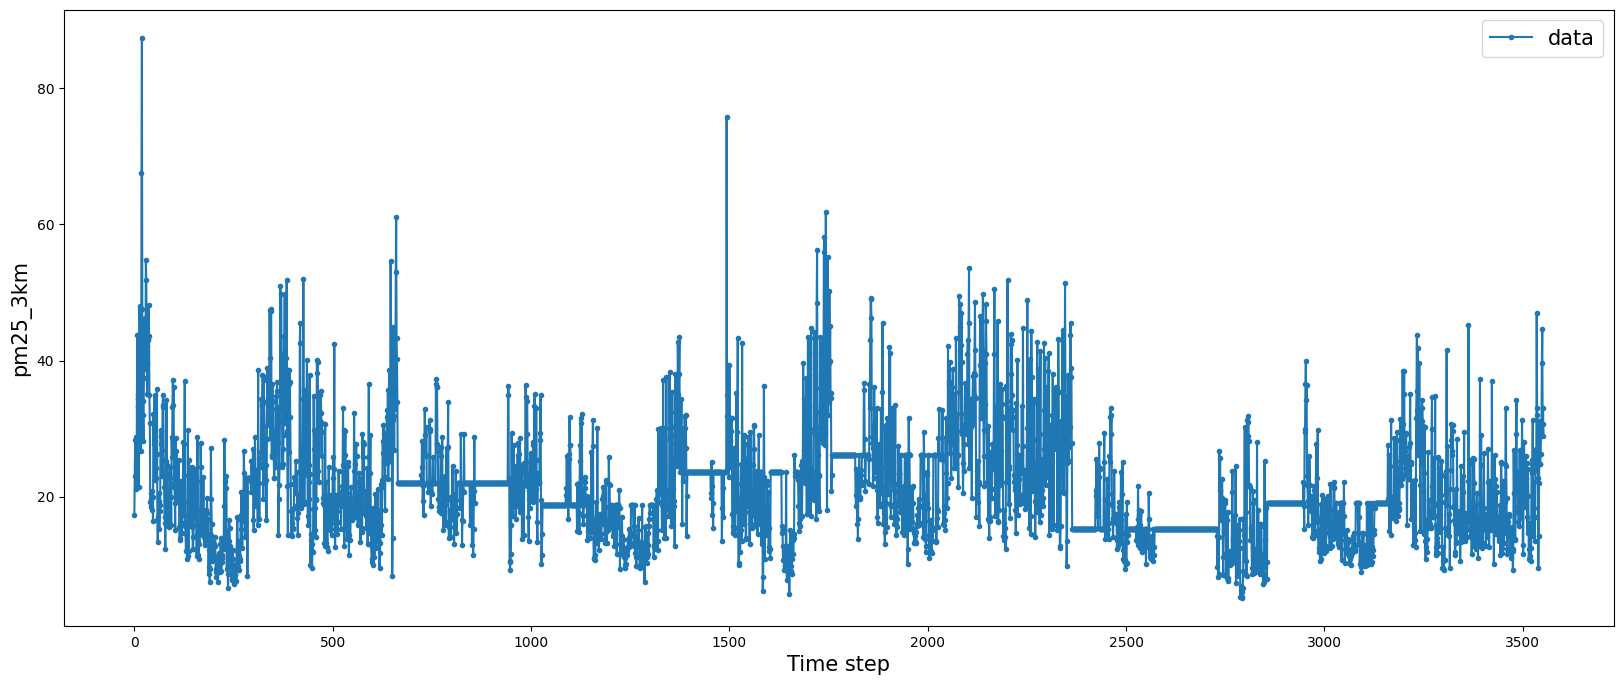

In [25]:
plot_1_data(data=y_mpair, datalabel="data", xlabel="Time step", ylabel="pm25_3km")

### Data normalization

In [26]:
mpair_features_scaler = MinMaxScaler()
X_mpair_scaled = mpair_features_scaler.fit_transform(X_mpair)
X_mpair_scaled = pd.DataFrame(X_mpair_scaled, columns=X_mpair.columns)
X_mpair_scaled

,lat,lon,pop,pm25_3km,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,hpbl,wspd,tmp,rh,station
0,0.333333,0.375,0.915791,0.404852,0.663059,0.547417,0.250325,0.000000,0.88279,0.000000,0.000000,0.163994,0.249630,0.709483,0.198457,0.344214,0.547004,0.291319,0.286051,0.0
1,0.333333,0.375,0.915791,0.630145,0.663059,0.547417,0.250325,0.000000,0.88279,0.000000,0.000000,0.163994,0.249630,0.709483,0.082887,0.347495,0.291679,0.255205,0.287664,0.0
2,0.333333,0.375,0.915791,0.632451,0.663059,0.547417,0.250325,0.000000,0.88279,0.000000,0.000000,0.163994,0.249630,0.709483,0.198457,0.303118,0.172290,0.379682,0.320079,0.0
3,0.333333,0.375,0.915791,0.689589,0.663059,0.547417,0.250325,0.000000,0.88279,0.000000,0.000000,0.163994,0.249630,0.709483,0.198457,0.406494,0.117574,0.460990,0.317816,0.0
4,0.333333,0.375,0.915791,0.792440,0.663059,0.547417,0.250325,0.000000,0.88279,0.000000,0.000000,0.163994,0.249630,0.709483,0.198457,0.448418,0.373988,0.443089,0.332085,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,0.333333,0.250,1.000000,0.351504,0.836319,0.000000,0.000000,0.060731,1.00000,0.000952,0.039683,0.000000,0.092678,0.653476,0.192077,0.300308,0.190684,0.144836,0.474597,1.0
3549,0.333333,0.250,1.000000,0.295950,0.836319,0.000000,0.000000,0.060731,1.00000,0.000952,0.039683,0.000000,0.092678,0.653476,0.192077,0.443115,0.261548,0.304301,0.314947,1.0
3550,0.333333,0.250,1.000000,0.266072,0.836319,0.000000,0.000000,0.060731,1.00000,0.000952,0.039683,0.000000,0.092678,0.653476,0.042601,0.571233,0.384038,0.304134,0.353262,1.0
3551,0.333333,0.250,1.000000,0.177692,0.836319,0.000000,0.000000,0.060731,1.00000,0.000952,0.039683,0.000000,0.092678,0.653476,0.192077,0.459059,0.623572,0.222773,0.285206,1.0


In [27]:
X_mpair_scaled.columns

Index(['lat', 'lon', 'pop', 'pm25_3km', 'road_den_1km', 'prim_road_len_1km',
       'near_dist', 'bareland', 'builtup', 'cropland', 'grassland',
       'treecover', 'water', 'ndvi', 'aod', 'hpbl', 'wspd', 'tmp', 'rh',
       'station'],
      dtype='object')

In [28]:
mpair_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_mpair_scaled = mpair_label_scaler.fit_transform(y_mpair)
y_mpair_scaled = pd.DataFrame(y_mpair_scaled, columns=y_mpair.columns)
y_mpair_scaled

,pm25
0,0.147032
1,0.216931
2,0.281258
3,0.287336
4,0.239218
...,...
3548,0.419453
3549,0.480472
3550,0.310835
3551,0.339606


## Dimensionality Reduction

Get the dimensionality reduction model from AOD data

### Data padding

In [29]:
padded_before = pd.DataFrame([X_mpair_scaled.iloc[0]] * conf["reduction"]["n_past"])
padded_after = pd.DataFrame([X_mpair_scaled.iloc[-1]] * (conf["reduction"]["n_future"] - 1))
X_mpair_scaled_padded = pd.concat([padded_before, X_mpair_scaled, padded_after], axis=0, ignore_index=True)

X_mpair_scaled_reframed, _ = reframePastFuture(X_mpair_scaled_padded, conf["reduction"]["n_past"], conf["reduction"]["n_future"])

print(X_mpair_scaled_reframed.shape)

(3553, 7, 20)


### Evaluation board

In [30]:
evaluation_board = {'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction':[], 'mae': []}

### Encoder model paths

In [31]:
lstm_s2s_encoder_model_path = '/le_thanh_van_118/workspace/hiep_workspace/model_info/aod_lstms2s_dim_reduction_17_features_encoder.keras'
gru_s2s_encoder_model_path = '/le_thanh_van_118/workspace/hiep_workspace/model_info/aod_grus2s_dim_reduction_16_features_encoder.keras'
cnnlstm_s2s_encoder_model_path = '/le_thanh_van_118/workspace/hiep_workspace/model_info/aod_lstms2s_dim_reduction_13_features_encoder.keras'

### Prediction + No dim reduction

In [32]:
# Prediction
y_pred, y_test = predictLSTM(X_mpair_scaled, y_mpair_scaled,
                         conf["prediction"]["n_past"], conf["prediction"]["n_future"], conf["prediction"]["epochs"], conf["prediction"]["batch_size"],
                         model_name=f"mpair_lstm_prediction_no_dim_reduction",
                         verbose=1)

# Evaluation
all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, mpair_label_scaler, verbose=0)
print(avg_mae)

Model: "mpair_lstm_prediction_no_dim_reduction"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 21)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 200),     │    177,600 │ input_layer[0][0] │
│                     │ (None, 200),      │            │                   │
│                     │ (None, 200)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 1, 200)    │          0 │ lstm[0][0]        │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 1, 200)    │    320,800 │ repeat_vector[0]… │
│                     │                   │            │ lstm[0][1],       │
│                     │                   │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 1, 100)    │     20,100 │ lstm_1[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 518,601 (1.98 MB)

 Trainable params: 518,601 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model mpair_lstm_prediction_no_dim_reduction...
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0884 - val_loss: 0.0722
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1310 - val_loss: 0.0581
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0868 - val_loss: 0.1018
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0720 - val_loss: 0.0670
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0796 - val_loss: 0.0649
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0833 - val_loss: 0.1083
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0880 - val_loss: 0.0507
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0889 - val_loss: 0.0708
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1018 - val_loss: 0.0597
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0699 - val_loss: 0.0512
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0766 - val_loss: 0.0494
E

inv_y_pred.shape = (709, 1)
inv_y_test.shape = (709, 1)


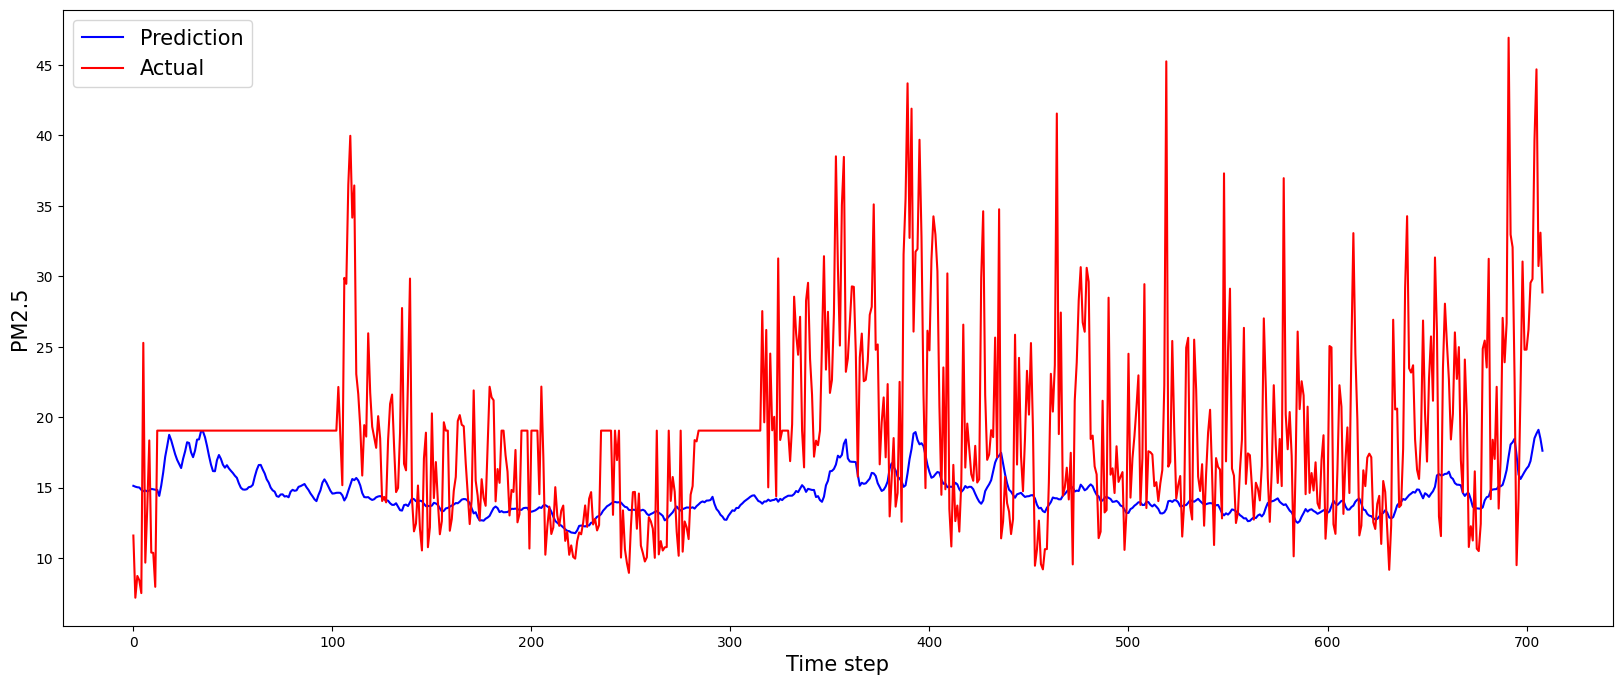

In [33]:
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="Prediction",
                datalabel2="Actual",
                xlabel="Time step",
                ylabel="PM2.5")

evaluation_board['dim_reduction_method'] += ["No"]
evaluation_board['dim_after_reduction'] += ["N/A"]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [avg_mae]

### Prediction + LSTM-Seq2Seq

In [34]:
# Load encoder model
lstm_s2s_encoder_model = load_model(lstm_s2s_encoder_model_path)
lstm_s2s_encoder_model_path = '/le_thanh_van_118/workspace/hiep_workspace/model_info/aod_lstms2s_dim_reduction_19_features_encoder.keras'
lstm_s2s_encoder_model.summary()
lstm_s2s_output_n_features = lstm_s2s_encoder_model.layers[-1].output.shape[-1]

# Encode the data
X_mpair_scaled_lstm_s2s_encoded = lstm_s2s_encoder_model.predict(X_mpair_scaled_reframed)

# Printout
pd.DataFrame(X_mpair_scaled_lstm_s2s_encoded)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "aod_lstms2s_dim_reduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,403 (931.27 KB)

 Trainable params: 79,467 (310.42 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 158,936 (620.85 KB)

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.194201,0.305446,0.150738,-0.100273,0.119749,-0.066507,0.327141,-0.001882,-0.064666,-0.273443,-0.363333,0.022780,0.147969,-0.139409,-0.088275,0.113263,0.057786
1,-0.194201,0.305446,0.150738,-0.100273,0.119749,-0.066507,0.327141,-0.001882,-0.064666,-0.273443,-0.363333,0.022780,0.147969,-0.139409,-0.088275,0.113263,0.057786
2,-0.192779,0.303369,0.149806,-0.097864,0.121402,-0.066027,0.326725,-0.002241,-0.066099,-0.271522,-0.361171,0.021903,0.146832,-0.139943,-0.088583,0.113874,0.058958
3,-0.191012,0.299724,0.149269,-0.093921,0.122710,-0.065093,0.325689,-0.001810,-0.067981,-0.266482,-0.358593,0.021161,0.143846,-0.139284,-0.087798,0.114388,0.060022
4,-0.188533,0.294920,0.147900,-0.088466,0.124445,-0.063332,0.322976,-0.001842,-0.070939,-0.259256,-0.355371,0.019899,0.139354,-0.138047,-0.086156,0.115176,0.062496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,-0.160488,0.318242,0.168234,-0.077426,0.140893,-0.070784,0.208488,-0.026516,-0.102186,-0.234725,-0.359892,0.055738,0.127155,-0.147322,-0.060034,0.145675,0.120881
3549,-0.159801,0.317890,0.167834,-0.077243,0.140355,-0.070436,0.209694,-0.026367,-0.102959,-0.235441,-0.358970,0.056091,0.127502,-0.146986,-0.059278,0.145260,0.120251
3550,-0.158810,0.316964,0.167543,-0.076765,0.139506,-0.070586,0.207385,-0.026653,-0.103640,-0.234278,-0.358225,0.057337,0.127049,-0.147074,-0.060025,0.144224,0.120987
3551,-0.158199,0.314061,0.165505,-0.076470,0.138050,-0.072029,0.205508,-0.028427,-0.103303,-0.232955,-0.356961,0.057267,0.127149,-0.147393,-0.059997,0.143177,0.121233


In [35]:
# Prediction
y_pred, y_test = predictLSTM(X_mpair_scaled_lstm_s2s_encoded, y_mpair_scaled,
                         conf["prediction"]["n_past"], conf["prediction"]["n_future"], conf["prediction"]["epochs"], conf["prediction"]["batch_size"],
                         model_name=f"mpair_lstm_prediction_with_lstms2s_dim_reduction_{lstm_s2s_output_n_features}_features",
                         verbose=1)

# Evaluation
all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, mpair_label_scaler, verbose=0)
print(avg_mae)

Model: "mpair_lstm_prediction_with_lstms2s_dim_reduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 200),     │    175,200 │ input_layer_1[0]… │
│                     │ (None, 200),      │            │                   │
│                     │ (None, 200)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 1, 200)    │          0 │ lstm_2[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 1, 200)    │    320,800 │ repeat_vector_1[… │
│                     │                   │            │ lstm_2[0][1],     │
│                     │                   │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 1, 100)    │     20,100 │ lstm_3[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 516,201 (1.97 MB)

 Trainable params: 516,201 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model mpair_lstm_prediction_with_lstms2s_dim_reduction_17_features...
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.1014 - val_loss: 0.0736
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0804 - val_loss: 0.0727
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0739 - val_loss: 0.1213
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0945 - val_loss: 0.0531
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0689 - val_loss: 0.0722
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0698 - val_loss: 0.0630
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0673 - val_loss: 0.0506
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0665 - val_loss: 0.0512
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0727 - val_loss: 0.0636
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0702 - val_loss: 0.0567
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.074

inv_y_pred.shape = (709, 1)
inv_y_test.shape = (709, 1)


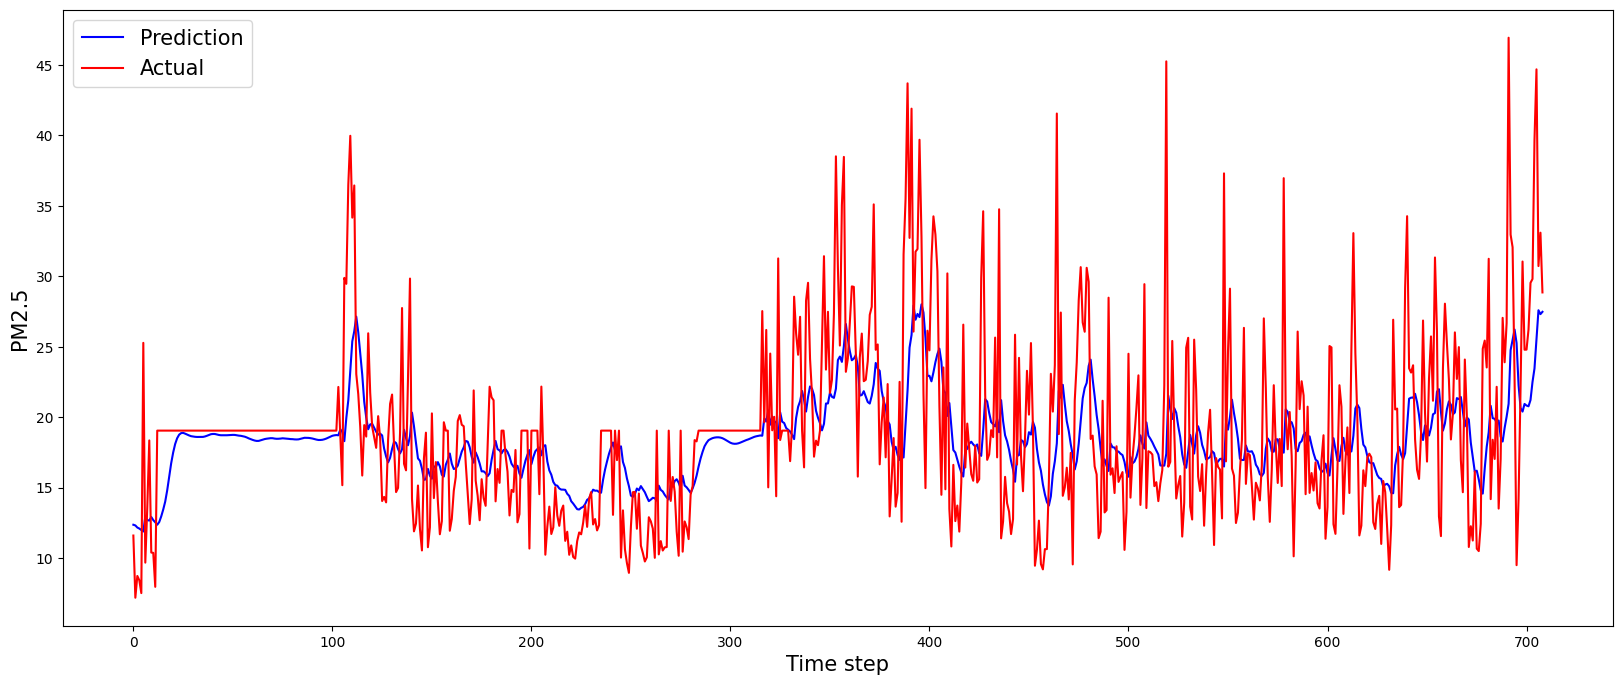

In [36]:
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="Prediction",
                datalabel2="Actual",
                xlabel="Time step",
                ylabel="PM2.5")

evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [lstm_s2s_output_n_features]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [avg_mae]

In [37]:
pd.DataFrame(evaluation_board)

,dim_reduction_method,dim_after_reduction,prediction,mae
0,No,N/A,LSTM,5.313322
1,LSTM-Seq2Seq,17,LSTM,3.788231


### Prediction + GRU-Seq2Seq

In [38]:
# Load encoder model
gru_s2s_encoder_model = load_model(gru_s2s_encoder_model_path)
gru_s2s_encoder_model.summary()
gru_s2s_output_n_features = gru_s2s_encoder_model.layers[-1].output.shape[-1]

# Encode the data
X_mpair_scaled_gru_s2s_encoded = gru_s2s_encoder_model.predict(X_mpair_scaled_reframed)

# Printout
pd.DataFrame(X_mpair_scaled_gru_s2s_encoded)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "aod_grus2s_dim_reduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_12 (GRU)                    │ (None, 7, 100)         │        36,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,650 (705.67 KB)

 Trainable params: 60,216 (235.22 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 120,434 (470.45 KB)

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.048485,0.050242,0.094467,0.070646,0.030935,0.040293,0.105954,0.045903,0.074029,0.084209,0.045029,0.058170,0.102928,0.039408,0.066110,0.043192
1,0.048485,0.050242,0.094467,0.070646,0.030935,0.040293,0.105954,0.045903,0.074029,0.084209,0.045029,0.058170,0.102928,0.039408,0.066110,0.043192
2,0.048747,0.049826,0.095269,0.069512,0.030679,0.039859,0.107648,0.046342,0.073885,0.083495,0.044800,0.058198,0.103640,0.039293,0.065656,0.043149
3,0.048889,0.049706,0.096271,0.068448,0.030302,0.039308,0.108866,0.046503,0.073807,0.083226,0.044591,0.058354,0.104385,0.039137,0.065263,0.042945
4,0.048921,0.049600,0.097562,0.067392,0.029769,0.038569,0.110225,0.046523,0.073958,0.082811,0.044298,0.058563,0.105454,0.038802,0.064848,0.042705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,0.058752,0.043387,0.100007,0.061464,0.027966,0.043150,0.128490,0.048191,0.067387,0.068678,0.041982,0.058319,0.104123,0.036407,0.059571,0.052126
3549,0.058600,0.043624,0.099514,0.061706,0.028247,0.043322,0.127708,0.048203,0.067374,0.068977,0.042162,0.058120,0.103933,0.036663,0.059503,0.052344
3550,0.058586,0.043946,0.099062,0.062147,0.028485,0.043724,0.126317,0.048096,0.067291,0.069186,0.042372,0.058269,0.103405,0.036827,0.059681,0.052608
3551,0.058559,0.043996,0.098992,0.062274,0.028584,0.044042,0.125635,0.047993,0.067584,0.069002,0.042513,0.058507,0.102965,0.036758,0.059778,0.052818


In [39]:
# Prediction
y_pred, y_test = predictLSTM(X_mpair_scaled_gru_s2s_encoded, y_mpair_scaled,
                         conf["prediction"]["n_past"], conf["prediction"]["n_future"], conf["prediction"]["epochs"], conf["prediction"]["batch_size"],
                         model_name=f"mpair_lstm_prediction_with_gru_dim_reduction_{gru_s2s_output_n_features}_features",
                         verbose=1)

# Evaluation
all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, mpair_label_scaler, verbose=0)
print(avg_mae)

Model: "mpair_lstm_prediction_with_gru_dim_reduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 200),     │    174,400 │ input_layer_2[0]… │
│                     │ (None, 200),      │            │                   │
│                     │ (None, 200)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 1, 200)    │          0 │ lstm_4[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 1, 200)    │    320,800 │ repeat_vector_2[… │
│                     │                   │            │ lstm_4[0][1],     │
│                     │                   │            │ lstm_4[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 1, 100)    │     20,100 │ lstm_5[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 515,401 (1.97 MB)

 Trainable params: 515,401 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model mpair_lstm_prediction_with_gru_dim_reduction_16_features...
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1300 - val_loss: 0.0532
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0816 - val_loss: 0.0498
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0812 - val_loss: 0.0693
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0689 - val_loss: 0.0562
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0680 - val_loss: 0.0493
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0669 - val_loss: 0.0475
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0660 - val_loss: 0.0536
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0583 - val_loss: 0.0498
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0681 - val_loss: 0.0456
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0581 - val_loss: 0.0476
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0653 - 

inv_y_pred.shape = (709, 1)
inv_y_test.shape = (709, 1)


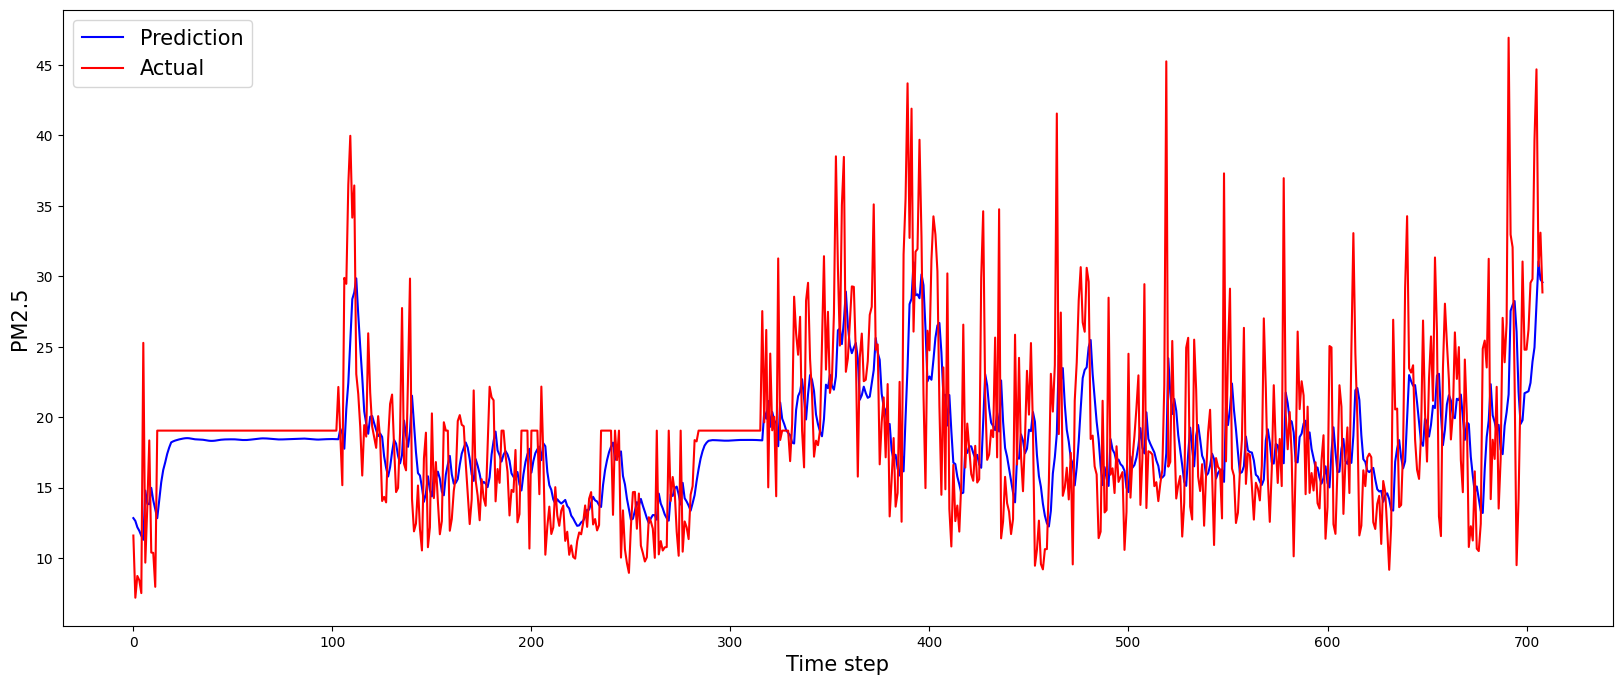

In [40]:
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="Prediction",
                datalabel2="Actual",
                xlabel="Time step",
                ylabel="PM2.5")

evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [gru_s2s_output_n_features]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [avg_mae]

In [41]:
pd.DataFrame(evaluation_board)

,dim_reduction_method,dim_after_reduction,prediction,mae
0,No,N/A,LSTM,5.313322
1,LSTM-Seq2Seq,17,LSTM,3.788231
2,GRU-Seq2Seq,16,LSTM,3.654748


### Prediction + CNNLSTM-Seq2Seq

In [2]:
# Load encoder model
cnnlstm_s2s_encoder_model = load_model(cnnlstm_s2s_encoder_model_path)
cnnlstm_s2s_encoder_model.summary()
cnnlstm_s2s_output_n_features = cnnlstm_s2s_encoder_model.layers[-1].output.shape[-1]

# Encode the data
X_mpair_scaled_cnnlstm_s2s_encoded = cnnlstm_s2s_encoder_model.predict(X_mpair_scaled_reframed)

# Printout
pd.DataFrame(X_mpair_scaled_cnnlstm_s2s_encoded)

NameError: name 'load_model' is not defined

In [43]:
# Prediction
y_pred, y_test = predictLSTM(X_mpair_scaled_cnnlstm_s2s_encoded, y_mpair_scaled,
                         conf["prediction"]["n_past"], conf["prediction"]["n_future"], conf["prediction"]["epochs"], conf["prediction"]["batch_size"],
                         model_name=f"mpair_cnnlstm_prediction_with_lstms2s_dim_reduction_{cnnlstm_s2s_output_n_features}_features",
                         verbose=1)

# Evaluation
all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, mpair_label_scaler, verbose=0)
print(avg_mae)

Model: "mpair_cnnlstm_prediction_with_lstms2s_dim_reduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 200),     │    172,000 │ input_layer_3[0]… │
│                     │ (None, 200),      │            │                   │
│                     │ (None, 200)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 1, 200)    │          0 │ lstm_6[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 1, 200)    │    320,800 │ repeat_vector_3[… │
│                     │                   │            │ lstm_6[0][1],     │
│                     │                   │            │ lstm_6[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 1, 100)    │     20,100 │ lstm_7[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 513,001 (1.96 MB)

 Trainable params: 513,001 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model mpair_cnnlstm_prediction_with_lstms2s_dim_reduction_13_features...
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1028 - val_loss: 0.1009
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1318 - val_loss: 0.0897
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0954 - val_loss: 0.0549
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0880 - val_loss: 0.1001
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0898 - val_loss: 0.0750
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0971 - val_loss: 0.0544
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0813 - val_loss: 0.0890
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0858 - val_loss: 0.0536
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0822 - val_loss: 0.0568
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0862 - val_loss: 0.0888
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.

inv_y_pred.shape = (709, 1)
inv_y_test.shape = (709, 1)


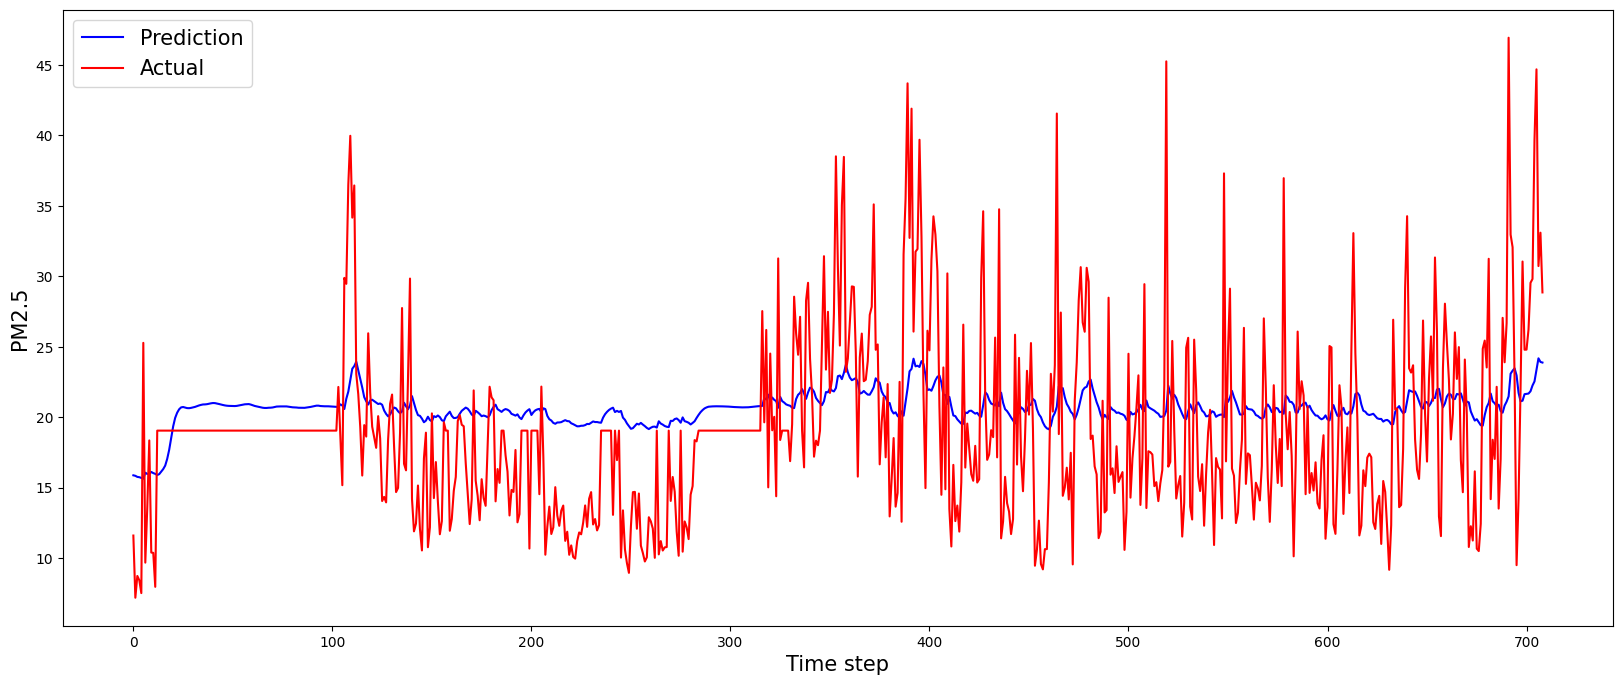

In [44]:
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="Prediction",
                datalabel2="Actual",
                xlabel="Time step",
                ylabel="PM2.5")

evaluation_board['dim_reduction_method'] += ["CNNLSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [cnnlstm_s2s_output_n_features]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [avg_mae]

In [1]:
pd.DataFrame(evaluation_board)

NameError: name 'pd' is not defined